In [332]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import matplotlib.patches as mpatches

from ete3 import NCBITaxa
from Bio import SeqIO
import taxoniq
import marisa_trie

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

In [333]:
ncbi = NCBITaxa()

In [334]:
# palette from here: https://flatuicolors.com/palette/us
official_colors = ['#55efc4','#00b894', #greens 
                   '#81ecec','#00cec9', #teals
                   '#74b9ff','#0984e3', #blues
                   '#a29bfe','#6c5ce7', #purples
                   '#ffeaa7','#fdcb6e', #yellows
                   '#fab1a0', '#e17055', #oranges
                   '#ff7675', '#d63031', #reds
                   '#fd79a8', '#e84393', #pinks
                   '#dfe6e9', '#b2bec3', '#636e72', '#2d3436' #greys
                  ]

In [335]:
# INPUT FILES
this_iteration = 'nanopore-2021_compressed_new_approach'
current_db = 'nt' #'nr' #'nt'

old_taxon_counts = "./data/BASELINE/Zymo-GridION-EVEN-BB-SN_Guppy_6.0.1_sup_report.csv"
new_taxon_counts = "./data/NEW/" + this_iteration + "/Zymo-GridION-EVEN-BB-SN_Guppy_6.0.1_sup_report.csv"


In [336]:
old_df = pd.read_csv(old_taxon_counts)
new_df = pd.read_csv(new_taxon_counts)

old_df = old_df[old_df.tax_level == 1][['tax_id', 'name', 'nt_bpm', 'nt_contigs', 'nr_bpm']]
new_df = new_df[new_df.tax_level == 1][['tax_id', 'name', 'nt_bpm', 'nt_contigs', 'nr_bpm']]

all_names = new_df['name']

new_names = []
for n in all_names:
    taxid = n.split()[-1]
    try:
        taxid2name = ncbi.get_taxid_translator([taxid])
        new_names.append(taxid2name[int(taxid)])        
    except:
        new_names.append("None")
        
new_df['fixed_name'] = new_df['name'] #new_names #only needed this "new_names" functionality when we had the bug with taxon names

full_df = pd.merge(left = old_df, right = new_df, how='outer', on='tax_id', suffixes = ['_old', '_new'])
full_df.head()

,tax_id,name_old,nt_bpm_old,nt_contigs_old,nr_bpm_old,name_new,nt_bpm_new,nt_contigs_new,nr_bpm_new,fixed_name
0,1296,Mammaliicoccus sciuri,1.279420,NaN,NaN,Mammaliicoccus sciuri,1.813640,NaN,NaN,Mammaliicoccus sciuri
1,240427,Lactobacillus paracollinoides,0.254590,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1590,Lactiplantibacillus plantarum,0.197621,NaN,NaN,Lactiplantibacillus plantarum,0.197621,NaN,NaN,Lactiplantibacillus plantarum
3,1597,Lacticaseibacillus paracasei,0.148789,NaN,NaN,Lacticaseibacillus paracasei,0.148789,NaN,NaN,Lacticaseibacillus paracasei
4,97478,Lactobacillus mucosae,0.047788,NaN,NaN,Lactobacillus mucosae,0.047788,NaN,NaN,Lactobacillus mucosae


In [337]:
full_df.dropna(subset=[(current_db+'_bpm_old'), (current_db+'_bpm_new')], how='all', inplace=True)
full_df['log_'+current_db+'_bpm_old'] = np.log(full_df[current_db+'_bpm_old'] + 1)
full_df['log_'+current_db+'_bpm_new'] = np.log(full_df[current_db+'_bpm_new'] + 1)

full_df.sort_values(by=current_db+'_bpm_old', ascending = False, inplace=True)
full_df.head()

full_df.fillna(0, inplace=True)
full_df['diff'] = full_df[current_db+'_bpm_old'] - full_df[current_db+'_bpm_new']
full_df['max_' + current_db + '_bpm'] = full_df[[current_db+'_bpm_old', current_db+'_bpm_new']].max(axis=1)
full_df['perc_diff'] = full_df['diff']/full_df['max_' + current_db+ '_bpm']

full_df.sort_values(by='diff', inplace=True)
top_diffs = full_df.head(5)
bottom_diffs = full_df.tail(5)

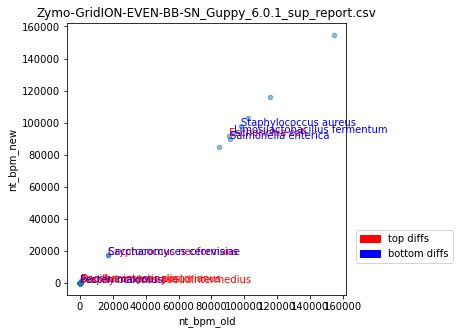

In [338]:
full_df.plot(kind='scatter', x = current_db + '_bpm_old', y = current_db+'_bpm_new', alpha = .5, figsize=(5,5))
plt.title(old_taxon_counts.split('/')[-1])
for i in top_diffs.index:
    plt.text(x = top_diffs.loc[i][current_db +'_bpm_old'], y = top_diffs.loc[i][current_db + '_bpm_new'], s = top_diffs.loc[i]['name_new'], color='red') #'fixed_name'
for i in bottom_diffs.index:
    plt.text(x = bottom_diffs.loc[i][current_db + '_bpm_old'], y = bottom_diffs.loc[i][current_db + '_bpm_new'], s = bottom_diffs.loc[i]['name_old'], color = 'blue')#, rotation=90)
    
patches = [mpatches.Patch(color='red', label='top diffs'), mpatches.Patch(color='blue', label='bottom diffs')]
plt.legend(handles=patches, loc='lower right', bbox_to_anchor=(1.4, .1))


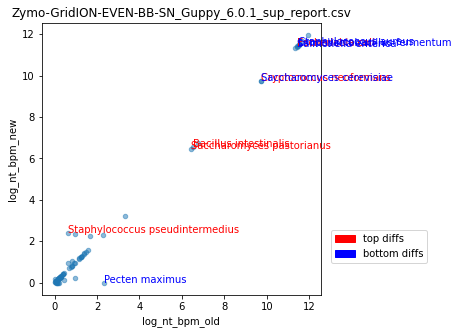

In [339]:
full_df.plot(kind='scatter', x = 'log_' +  current_db +'_bpm_old', y = 'log_' + current_db + '_bpm_new', alpha = .5, figsize=(5,5))
plt.title(old_taxon_counts.split('/')[-1])
for i in top_diffs.index:
    plt.text(x = top_diffs.loc[i]['log_' + current_db + '_bpm_old'], y = top_diffs.loc[i]['log_' +  current_db+ '_bpm_new'], s = top_diffs.loc[i]['name_new'], color='red') #'fixed_name'
for i in bottom_diffs.index:
    plt.text(x = bottom_diffs.loc[i]['log_' + current_db + '_bpm_old'], y = bottom_diffs.loc[i]['log_' + current_db + '_bpm_new'], s = bottom_diffs.loc[i]['name_old'], color='blue')
    
plt.legend(handles=patches, loc='lower right', bbox_to_anchor=(1.4, .1))


In [340]:
top_diffs

,tax_id,name_old,nt_bpm_old,nt_contigs_old,nr_bpm_old,name_new,nt_bpm_new,nt_contigs_new,nr_bpm_new,fixed_name,log_nt_bpm_old,log_nt_bpm_new,diff,max_nt_bpm,perc_diff
75,562,Escherichia coli,90671.400000,0.0,1900.470,Escherichia coli,91877.10000,0.0,1866.950,Escherichia coli,11.415008,11.428218,-1205.700000,91877.10000,-0.013123
30,5207,Cryptococcus neoformans,17065.900000,0.0,12693.000,Cryptococcus neoformans,17094.60000,0.0,12709.500,Cryptococcus neoformans,9.744896,9.746576,-28.700000,17094.60000,-0.001679
33,27292,Saccharomyces pastorianus,614.690000,0.0,180.381,Saccharomyces pastorianus,638.77400,0.0,180.381,Saccharomyces pastorianus,6.422744,6.461115,-24.084000,638.77400,-0.037703
62,283734,Staphylococcus pseudintermedius,0.902126,0.0,0.000,Staphylococcus pseudintermedius,9.83491,0.0,0.000,Staphylococcus pseudintermedius,0.642972,2.382773,-8.932784,9.83491,-0.908273
47,1963032,Bacillus intestinalis,688.681000,0.0,0.000,Bacillus intestinalis,696.74700,0.0,0.000,Bacillus intestinalis,6.536229,6.547857,-8.066000,696.74700,-0.011577


In [341]:
bottom_diffs

,tax_id,name_old,nt_bpm_old,nt_contigs_old,nr_bpm_old,name_new,nt_bpm_new,nt_contigs_new,nr_bpm_new,fixed_name,log_nt_bpm_old,log_nt_bpm_new,diff,max_nt_bpm,perc_diff
6,1613,Limosilactobacillus fermentum,93578.50000,0.0,0.0,Limosilactobacillus fermentum,93572.0,0.0,0.0,Limosilactobacillus fermentum,11.446567,11.446497,6.50000,93578.50000,0.000069
22,6579,Pecten maximus,9.16964,0.0,0.0,0,0.0,0.0,0.0,0,2.319407,0.000000,9.16964,9.16964,1.000000
64,1280,Staphylococcus aureus,98084.30000,0.0,87755.6,Staphylococcus aureus,98072.5,0.0,87742.1,Staphylococcus aureus,11.493593,11.493472,11.80000,98084.30000,0.000120
34,4932,Saccharomyces cerevisiae,17043.40000,0.0,14705.6,Saccharomyces cerevisiae,17013.6,0.0,14689.4,Saccharomyces cerevisiae,9.743577,9.741827,29.80000,17043.40000,0.001748
70,28901,Salmonella enterica,91122.80000,0.0,67443.8,Salmonella enterica,89903.5,0.0,65088.9,Salmonella enterica,11.419974,11.406503,1219.30000,91122.80000,0.013381


In [342]:
new_organisms_df = full_df[full_df.nt_bpm_old == 0]
new_organisms_df.sort_values(by=current_db + '_bpm_new', ascending = False, inplace=True)
new_organisms_df.head()

/Users/katrina.kalantar/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,tax_id,name_old,nt_bpm_old,nt_contigs_old,nr_bpm_old,name_new,nt_bpm_new,nt_contigs_new,nr_bpm_new,fixed_name,log_nt_bpm_old,log_nt_bpm_new,diff,max_nt_bpm,perc_diff
86,82688,0,0.0,0.0,0.0,Liquorilactobacillus nagelii,0.184682,0.0,0.0,Liquorilactobacillus nagelii,0.0,0.169474,-0.184682,0.184682,-1.0
87,1580,0,0.0,0.0,0.0,Levilactobacillus brevis,0.049666,0.0,0.0,Levilactobacillus brevis,0.0,0.048472,-0.049666,0.049666,-1.0


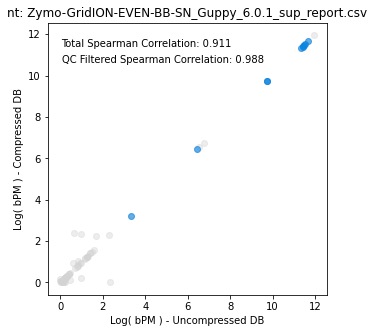

In [343]:
# correlation when removing the taxa that are low-abundance hits on either new or old

def plot_filtered_spearman2(input_data, cdb):
    input_data['log_'+cdb+'_bpm_new'] = np.log(input_data[cdb+'_bpm_new'] + 1)
    input_data['log_'+cdb+'_bpm_old'] = np.log(input_data[cdb+'_bpm_old'] + 1)
    
    cdb_color_dict = {'nt': official_colors[5], 'nr': official_colors[11]}

    input_data2 = input_data[input_data['nt_bpm_new'] >= 10]
    input_data3 = input_data2[input_data2['nr_bpm_new'] >= 1]

    plt.scatter(input_data['log_' + cdb + '_bpm_old'], input_data['log_' + cdb + '_bpm_new'], alpha = .4, color = 'lightgrey')
    plt.scatter(input_data3['log_' + cdb + '_bpm_old'], input_data3['log_' + cdb + '_bpm_new'], alpha = .6, color = cdb_color_dict[cdb])
    plt.title(cdb + ': ' + old_taxon_counts.split('/')[-1])

    total_spearman = stats.spearmanr(input_data[cdb + '_bpm_old'], input_data[cdb + '_bpm_new'])[0]
    filtered_spearman = stats.spearmanr(input_data3[cdb + '_bpm_old'], input_data3[cdb + '_bpm_new'])[0] 

    plt.text(x = 0.05, y = 11.4, s = "Total Spearman Correlation: " + str(np.round(total_spearman,3)), color='black')
    plt.text(x = 0.05, y = 10.6, s = "QC Filtered Spearman Correlation: " + str(np.round(filtered_spearman,3)), color='black')    
    plt.xlabel("Log( bPM ) - Uncompressed DB")
    plt.ylabel("Log( bPM ) - Compressed DB")
    

plt.figure(figsize=(5,5))
plot_filtered_spearman2(full_df, current_db)
plt.savefig("./nanopore_correlation_plots_" + current_db + ".pdf")
